# Lecture 8 - Time Series Analysis

In this notebook we will learn how to perform time series analysis of Twitter data. 

<ol type = 1>
<li> Data processing</li>
    <ol type = a>
    <li> Load users' tweets</li>
    <li> Convert tweet times into datetime objects</li>
    <li> Shift times of tweets</li>
    </ol>
<li> Tweet rate</li>
    <ol type = a>
    <li> Calculate mean tweet rate</li>
    <li> Calculate rolling window tweet rate</li>
    <li> Word clouds of tweets in a specific time window </li>
    <li>Calculate rolling average of retweet count </li>
    <li>Calculate rolling average of sentiment </li>
    </ol>
 
<li>Tweet hours and days</li>
<ol type = a>
<li>Histograms of tweet hour and day of the week </li>
<li> Word clouds for tweets on a certain hour or day of the week </li>
</ol>

<li> Geo-location using high low model </li>
</ol>
</ol>

This notebook can be opened in Colab 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture08_TimeSeriesAnalysis.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.

# Clones, installs, and imports


## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [1]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 185 (delta 101), reused 123 (delta 42), pack-reused 0
Receiving objects: 100% (185/185), 12.51 MiB | 5.76 MiB/s, done.
Resolving deltas: 100% (101/101), done.


## Install Requirements 

In [ ]:
!pip install -r requirements.txt



## Import Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import scripts.TextAnalysis as ta
from scripts.api import *

pd.set_option("display.max_colwidth", None)


# Data Processing

##  Load data

Load the tweets in the file `"data/lecture_04.db"` into a dataframe. Then load the sentiment of the tweets from `"data/lec_08_tweets_sentiment.csv"`.  Finally, join the dataframes together to get one big dataframe with the tweets, their creation times, and sentiment.  We join the dataframes on the `"id"` column, which provides a unique identifier for each tweet.


In [4]:
#tweets from database
fname_db = "data/lecture_04"
df_all = DB.fetch(table_name = 'user_tweets', path = fname_db)

#tweet sentiment from csv file
df_sentiment = pd.read_csv("data/lec_08_tweets_sentiment.csv")
df_sentiment = df_sentiment[['id','sentiment']]

#join dataframes together, merging on the "id" column
df_all['id'] = df_all['id'].astype(float, errors = 'raise')
df_all = df_all.set_index('id').join(df_sentiment.set_index('id'))

df_all.screen_name.unique()

array(['sanbenito', 'dogecoin', 'BarackObama', 'kanyewest',
       'MichelleObama', 'JBALVIN', 'KingJames', 'AOC', 'KimKardashian',
       'RashidaTlaib', 'elonmusk'], dtype=object)

In [5]:
df_all.head()


,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,author_id,conversation_id,in_reply_to_user_id,geo,sentiment
id,,,,,,,,,,,,,
1.212227e+18,2020-01-01T04:18:19.000Z,sanbenito,HI 2020 ✌🏻,und,23814,980,85439,817,1059542139737128960,1212226519818481665,nan,None,3.394649
1.212277e+18,2020-01-01T07:38:09.000Z,dogecoin,RT @RacerDoge: Here's to another Doge-tastic year!\n#NewYear2020 #dogecoin https://t.co/fOEy27GL2p,en,15,0,0,0,2235729541,1212276812220420096,nan,None,3.693833
1.212422e+18,2020-01-01T17:16:44.000Z,BarackObama,"Here’s to a happy, healthy, and hopeful 2020. Happy New Year, everybody!",en,123882,21384,1014384,5560,813286,1212422416716247040,nan,None,4.841946
1.212884e+18,2020-01-02T23:49:54.000Z,BarackObama,"With David Stern’s passing, I’m reflecting on everything he did to take the NBA global, creating entire new generations of fans pretending to be like Mike or any of their favorite players on driveways and playgrounds around the world. https://t.co/8QMCazx2Fs",en,5836,2627,82579,372,813286,1212883749727158273,nan,None,4.369432
1.212975e+18,2020-01-03T05:50:37.000Z,kanyewest,happy new decade from the ranch https://t.co/7XhVVBEG4I,en,13075,2573,170435,2393,169686021,1212974525781925888,nan,None,4.544683


## Datetimes

Right now the tweet time is in the `created_at` column as a string.  To do time series analysis we have to convert it to a `datetime` object.  This can be done using the `to_datetime` function.  We have to specify the format of the date and time in the string.  We do this using the string variable `format`.  The `created_at` format is "year-month-date hour:minute:second".  In Python, this format is defined as `format = "%Y-%m-%d %H:%M:%S"`. 

We add a column `created_at_datetime` to the dataframe which is the `created_at` column converted to datetimes.  

In [6]:
format = "%Y-%m-%d %H:%M:%S"
df_all['created_at_datetime'] = pd.to_datetime(df_all['created_at'],format=format).dt.tz_localize(None)
df_all.head()

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,author_id,conversation_id,in_reply_to_user_id,geo,sentiment,created_at_datetime
id,,,,,,,,,,,,,,
1.212227e+18,2020-01-01T04:18:19.000Z,sanbenito,HI 2020 ✌🏻,und,23814,980,85439,817,1059542139737128960,1212226519818481665,nan,None,3.394649,2020-01-01 04:18:19
1.212277e+18,2020-01-01T07:38:09.000Z,dogecoin,RT @RacerDoge: Here's to another Doge-tastic year!\n#NewYear2020 #dogecoin https://t.co/fOEy27GL2p,en,15,0,0,0,2235729541,1212276812220420096,nan,None,3.693833,2020-01-01 07:38:09
1.212422e+18,2020-01-01T17:16:44.000Z,BarackObama,"Here’s to a happy, healthy, and hopeful 2020. Happy New Year, everybody!",en,123882,21384,1014384,5560,813286,1212422416716247040,nan,None,4.841946,2020-01-01 17:16:44
1.212884e+18,2020-01-02T23:49:54.000Z,BarackObama,"With David Stern’s passing, I’m reflecting on everything he did to take the NBA global, creating entire new generations of fans pretending to be like Mike or any of their favorite players on driveways and playgrounds around the world. https://t.co/8QMCazx2Fs",en,5836,2627,82579,372,813286,1212883749727158273,nan,None,4.369432,2020-01-02 23:49:54
1.212975e+18,2020-01-03T05:50:37.000Z,kanyewest,happy new decade from the ranch https://t.co/7XhVVBEG4I,en,13075,2573,170435,2393,169686021,1212974525781925888,nan,None,4.544683,2020-01-03 05:50:37


## Select Tweets of  a Screen Name 

Choose a `screen_name` from those in `df_all`.  We will study this user's tweets.

We will be making word clouds, so apply the `clean_tweet` function to the `text` column and add this as a new column `text_clean` to the dataframe.


In [7]:
screen_name = 'BarackObama'

df = df_all[df_all.screen_name==screen_name].copy()
df['text_clean'] = df.text.apply(ta.clean_tweet)  #clean the tweets

ntweets = len(df)
print(f"dataframe has {ntweets} tweets")
df.head()

dataframe has 671 tweets


,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,author_id,conversation_id,in_reply_to_user_id,geo,sentiment,created_at_datetime,text_clean
id,,,,,,,,,,,,,,,
1.212422e+18,2020-01-01T17:16:44.000Z,BarackObama,"Here’s to a happy, healthy, and hopeful 2020. Happy New Year, everybody!",en,123882,21384,1014384,5560,813286,1212422416716247040,nan,None,4.841946,2020-01-01 17:16:44,heres to a happy healthy and hopeful 2020 happy new year everybody
1.212884e+18,2020-01-02T23:49:54.000Z,BarackObama,"With David Stern’s passing, I’m reflecting on everything he did to take the NBA global, creating entire new generations of fans pretending to be like Mike or any of their favorite players on driveways and playgrounds around the world. https://t.co/8QMCazx2Fs",en,5836,2627,82579,372,813286,1212883749727158273,nan,None,4.369432,2020-01-02 23:49:54,with david sterns passing im reflecting on everything he did to take the nba global creating entire new generations of fans pretending to be like mike or any of their favorite players on driveways and playgrounds around the world
1.215378e+18,2020-01-09T21:00:08.000Z,BarackObama,The catastrophic fires in Australia are the latest example of the very real and very urgent consequences of climate change. It’s on us to stay focused and protect the one planet we’ve got for the next generation: https://t.co/dqytauPeXf,en,34895,9713,198516,2470,813286,1215377738858663937,nan,None,3.783579,2020-01-09 21:00:08,the catastrophic fires in australia are the latest exle of the very real and very urgent consequences of climate change its on us to stay focused and protect the one planet weve got for the next generation
1.215378e+18,2020-01-09T21:01:14.000Z,BarackObama,"Here’s the thing: Even with problems of this magnitude, each of us can still find a way to make change. That’s why I’m proud of young people like Alice Mahar, a environmental activist in Melbourne. Read about her and find ways you can help, too: https://t.co/qAHFiBgw6b",en,5448,1585,36678,272,813286,1215377738858663937,813286,None,3.780838,2020-01-09 21:01:14,heres the thing even with problems of this magnitude each of us can still find a way to make change thats why im proud of young people like alice mahar a environmental activist in melbourne read about her and find ways you can help too
1.216429e+18,2020-01-12T18:35:50.000Z,BarackObama,"Our fellow Americans in Puerto Rico can use our support after this week’s earthquakes. They’ve shown their enduring spirit over the past couple years, and it’s up to us to pull together for one another once again. I hope you’ll support their recovery: https://t.co/rYhSb8uVXK",en,29063,3767,129241,1943,813286,1216428587328458754,nan,None,4.473977,2020-01-12 18:35:50,our fellow americans in puerto rico can use our support after this weeks earthquakes theyve shown their enduring spirit over the past couple years and its up to us to pull together for one another once again i hope youll support their recovery


## Shifting Timezone

The `created_at` field is in Coordinated Universal Time (UTC), which is the time in London.  If you want to shift the time to a different timezon, just add your local offset.

For example, New York is -4 UTC, so we just add -4 hours to the UTC time.  This can be done using `timedelata64` object.  You specify you want hours with the string `'h'`, and the number of hours.  We will add this column to the dataframe and call it `created_at_datetime_ny`.

In [8]:
df['created_at_datetime_ny'] = df['created_at_datetime'] + np.timedelta64(-4, 'h')
df.head()

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,author_id,conversation_id,in_reply_to_user_id,geo,sentiment,created_at_datetime,text_clean,created_at_datetime_ny
id,,,,,,,,,,,,,,,,
1.212422e+18,2020-01-01T17:16:44.000Z,BarackObama,"Here’s to a happy, healthy, and hopeful 2020. Happy New Year, everybody!",en,123882,21384,1014384,5560,813286,1212422416716247040,nan,None,4.841946,2020-01-01 17:16:44,heres to a happy healthy and hopeful 2020 happy new year everybody,2020-01-01 13:16:44
1.212884e+18,2020-01-02T23:49:54.000Z,BarackObama,"With David Stern’s passing, I’m reflecting on everything he did to take the NBA global, creating entire new generations of fans pretending to be like Mike or any of their favorite players on driveways and playgrounds around the world. https://t.co/8QMCazx2Fs",en,5836,2627,82579,372,813286,1212883749727158273,nan,None,4.369432,2020-01-02 23:49:54,with david sterns passing im reflecting on everything he did to take the nba global creating entire new generations of fans pretending to be like mike or any of their favorite players on driveways and playgrounds around the world,2020-01-02 19:49:54
1.215378e+18,2020-01-09T21:00:08.000Z,BarackObama,The catastrophic fires in Australia are the latest example of the very real and very urgent consequences of climate change. It’s on us to stay focused and protect the one planet we’ve got for the next generation: https://t.co/dqytauPeXf,en,34895,9713,198516,2470,813286,1215377738858663937,nan,None,3.783579,2020-01-09 21:00:08,the catastrophic fires in australia are the latest exle of the very real and very urgent consequences of climate change its on us to stay focused and protect the one planet weve got for the next generation,2020-01-09 17:00:08
1.215378e+18,2020-01-09T21:01:14.000Z,BarackObama,"Here’s the thing: Even with problems of this magnitude, each of us can still find a way to make change. That’s why I’m proud of young people like Alice Mahar, a environmental activist in Melbourne. Read about her and find ways you can help, too: https://t.co/qAHFiBgw6b",en,5448,1585,36678,272,813286,1215377738858663937,813286,None,3.780838,2020-01-09 21:01:14,heres the thing even with problems of this magnitude each of us can still find a way to make change thats why im proud of young people like alice mahar a environmental activist in melbourne read about her and find ways you can help too,2020-01-09 17:01:14
1.216429e+18,2020-01-12T18:35:50.000Z,BarackObama,"Our fellow Americans in Puerto Rico can use our support after this week’s earthquakes. They’ve shown their enduring spirit over the past couple years, and it’s up to us to pull together for one another once again. I hope you’ll support their recovery: https://t.co/rYhSb8uVXK",en,29063,3767,129241,1943,813286,1216428587328458754,nan,None,4.473977,2020-01-12 18:35:50,our fellow americans in puerto rico can use our support after this weeks earthquakes theyve shown their enduring spirit over the past couple years and its up to us to pull together for one another once again i hope youll support their recovery,2020-01-12 14:35:50


## Heads and Tails

It's nice to sort the dataframe rows by the `created_at_datetime` column.  We can do this using the `sort_values` function.  Sort with `ascending=True` so that the first rows are the earliest tweets. Use the option `inplace=True` to have the dataframe be equal to its sorted version. 

To look at the first rows in the dataframe we use the `head` command.

To look at the last rows in the dataframe we use the `tail` command.

In [9]:
df.sort_values(by = 'created_at_datetime', inplace = True, ascending = True)
print(f"Head:\n{df.created_at.head()}")
print(f"Tail:\n{df.created_at.tail()}")



Head:
id
1.212422e+18    2020-01-01T17:16:44.000Z
1.212884e+18    2020-01-02T23:49:54.000Z
1.215378e+18    2020-01-09T21:00:08.000Z
1.215378e+18    2020-01-09T21:01:14.000Z
1.216429e+18    2020-01-12T18:35:50.000Z
Name: created_at, dtype: object
Tail:
id
1.486452e+18    2022-01-26T21:32:36.000Z
1.486731e+18    2022-01-27T16:00:44.000Z
1.487131e+18    2022-01-28T18:29:18.000Z
1.487131e+18    2022-01-28T18:31:10.000Z
1.487176e+18    2022-01-28T21:30:06.000Z
Name: created_at, dtype: object


# Tweet Rate

## Mean Tweet Rate

To calculate the mean tweet rate, we find the number of tweets and divide it by the duration they span.  The number of tweets `ntweets` is just the number of rows in the dataframe, which you can obtain using the `len` function.  The duration of the tweets `duration` is found by subtracting the datetime of the earliest tweet from the datetime of the most recent tweets.  

To obtain the earliest time we can use the `min` function.  To obtain the most recent time we can use the `max` function.

`duration` is a `TimeDelta` object.  To make things simple, we convert it to a number of days using the `days` parameter.

The `rate_estimate` is `ntweets` divided by `duration`.



In [10]:
ntweets = len(df)  #number of tweets

duration = df.created_at_datetime.max()-df.created_at_datetime.min()  #duration in TimeDelta
duration = duration.days #duration in days

rate_estimate = ntweets/duration  #rate [tweets/day]

print(f'Rate estimate = {rate_estimate:.2f} tweets per day')


Rate estimate = 0.89 tweets per day


## Rolling Window Tweet Rate

To obtain the rolling window tweet rate, we can make use of the `rolling` function.  This function creates a dataframe with rows grouped together if they are in a window specified by the row.  The `rolling` function is sort of like the `groupby` function we used before.

We will specify the windows as being a fixed amount of time before the value in the `created_at_datetime` column.  If we wanted a 1 day window, we use the format `rolling('1D',on='created_at_datetime'`.  If we wanted a 7 day window, we use the format `rolling('7D',on='created_at_datetime'`. After applying `rolling`, we need to apply another function to get the rate.  We want to know the number of tweets in the window.  To do this we create a column `tweet_indicator` that is 1 for every tweet.  Then to get the number of tweets in the window we apply`sum` after `rolling` to the `tweet_indicator` column.  

The rate will be in units of tweets/day. If the window is 1 day, then after applying `sum` you have the rate in the proper units.  If the window is 7 days, you need to divide the `sum` by 7 to get the proper units.

We add the rates to the dataframe as columns called `rate_1D` and `rate_7D`.



In [11]:
df['tweet_indicator'] = np.ones(len(df))
df['rate_1D'] = df.rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']
df['rate_7D'] = df.rolling('7D',on = 'created_at_datetime').sum()['tweet_indicator']/7



## Plot Rate

The `lineplot` function allows us to plot the rate with different window sizes.  You can set the x-axis limits with the `xlim` command. The values are datetime objects, which are specified by `datetime.date(year,month,date)`.  Set a `label` for each line you plot.  The use the `legend` function to produce a legend with the labels.

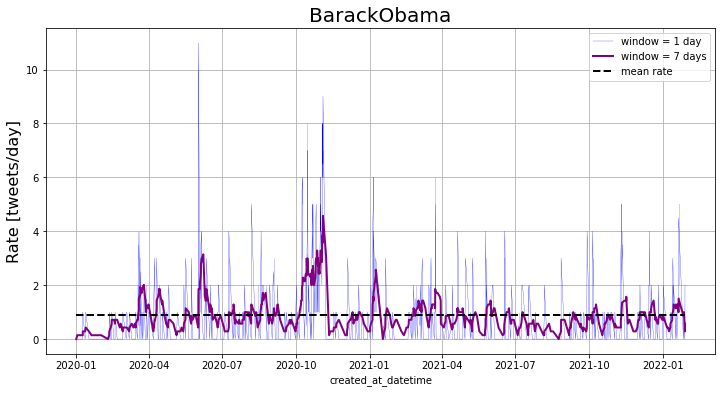

In [15]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df, x = 'created_at_datetime',y = 'rate_1D',label = 'window = 1 day',linewidth = .25,color = 'blue')
sns.lineplot(data = df, x = 'created_at_datetime',y = 'rate_7D',label = 'window = 7 days', linewidth = 2,color = 'purple')

plt.plot(df.created_at_datetime,rate_estimate*np.ones(len(df)),label = 'mean rate',linestyle = '--',linewidth = 2,color = 'black')

plt.grid()
plt.xlabel("Time", fontsize = 14)

plt.ylabel("Rate [tweets/day]", fontsize = 14)
#plt.xlim(datetime.date(2020, 10, 1),datetime.date(2021,1,1))
#plt.ylim([0,30])
plt.title(f"{screen_name}",fontsize = 20)

plt.legend()
plt.show()

## Tweets During Peak Tweet Rate

Let's find the datetime when the tweet rate with a 1 day window is maximal and call this value `tpeak`.  We do this with the logical condition `df.rate_1D==df.rate_1D.max()`, and then getting the value in the `created_at_datetime` column.

In [16]:
tpeak = df[df.rate_1D==df.rate_1D.max()].created_at_datetime.values[0]
print(f"Peak tweet rate on {tpeak}")


Peak tweet rate on 2020-06-01T23:59:01.000000000


## Peak Rate Tweets

We can make a dataframe of the tweets within a 24 hour window ending at `tpeak`.  We specify `t0` and `t1` as the start and stop stime for the window.  Then we use the logical condition  `(df.created_at_datetime>=t0) & (df.created_at_datetime<t1)` to get all tweets in this window and call the resulting dataframe `df1`.



In [18]:
t0 = tpeak - np.timedelta64(24, 'h')
t1 = tpeak 
df1 = df[(df.created_at_datetime>=t0) & (df.created_at_datetime<t1)]




In [19]:
df1[['text']]

,text
id,
1.267460e+18,I wrote out some thoughts on how to make this moment a real turning point to bring about real change––and pulled together some resources to help young activists sustain the momentum by channeling their energy into concrete action. https://t.co/jEczrOeFdv
1.267534e+18,"As millions of people across the country take to the streets and raise their voices in response to the killing of George Floyd and the ongoing problem of unequal justice, I’ve heard many ask how we can sustain momentum to bring about real change."
1.267534e+18,"Ultimately, it’s going to be up to a new generation of activists to shape strategies that best fit the times. But I want to highlight some basic lessons from past efforts that are worth remembering:"
1.267534e+18,1. The protests represent a genuine and legitimate frustration over a decades-long failure to reform police practices and the broader criminal justice system. We should condemn the few who resort to violence––not the overwhelming majority who deserve our respect and support.
1.267534e+18,"2. The point of protest is to raise public awareness, to put a spotlight on injustice, and to make the powers that be uncomfortable. But eventually, we have to translate those aspirations into specific laws and institutional practices."
1.267534e+18,"3. To do that, we have to know which levels of government have the biggest impact. Changing the federal government is important. But the elected officials who matter most in reforming police departments and the criminal justice system work at the state and local levels."
1.267534e+18,"4. So if we want to bring about real change, the choice isn’t between protest and politics––we have to do both. We have to mobilize to raise awareness, and we have to organize and cast our ballots to make sure that we elect candidates who will act on reform."
1.267534e+18,"5. The more specific we can make demands for criminal justice and police reform, the harder it will be for elected officials to just offer lip service to the cause and then fall back into business as usual once protests have gone away."
1.267534e+18,"I know the past few months have been hard and dispiriting. But watching the heightened activism of young people makes me hopeful. And if we can keep channeling our justifiable anger into peaceful, sustained, and effective action, this can be the moment when real change starts."


## Word Cloud of Peak Tweets

We can make a wordcloud of the peak rate tweets to understand what was driving the increased activity that day.

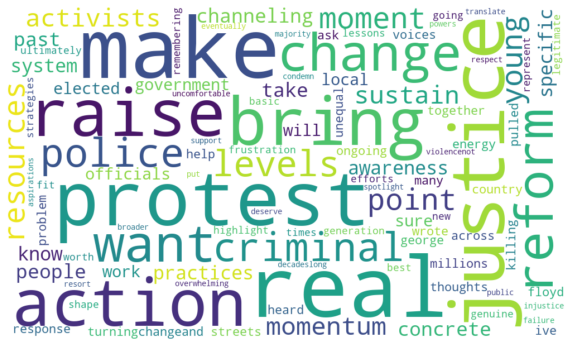

In [20]:
stopwords = set(STOPWORDS)
text=' '.join(df1.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)

fig = plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Rolling Average of Retweet Count

We can use the `rolling` function to plot rolling averages of numerical quantities like `retweet_count`.  We just apply the `mean` function.  

In [21]:
df['retweet_count_1D'] = df.rolling('1D',on = 'created_at_datetime').mean()['retweet_count']
df['retweet_count_7D'] = df.rolling('7D',on = 'created_at_datetime').mean()['retweet_count']


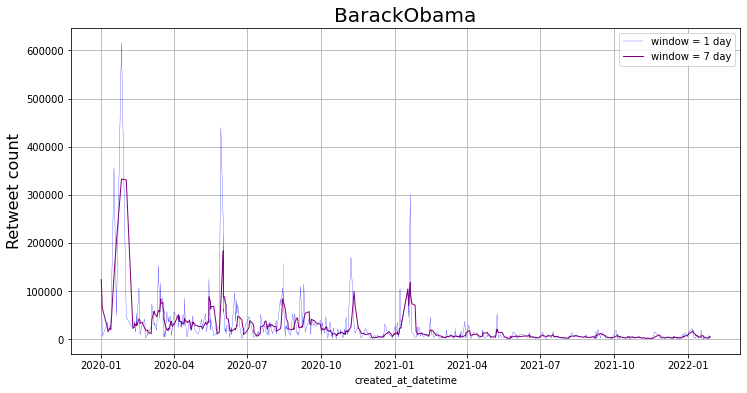

In [22]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df, x = 'created_at_datetime',y = 'retweet_count_1D',label = 'window = 1 day',
             linewidth = .25,color = 'blue')
sns.lineplot(data = df, x = 'created_at_datetime',y = 'retweet_count_7D',label = 'window = 7 day',
             linewidth = 1,color = 'purple')


plt.grid()
plt.ylabel("Retweet count",fontsize = 16)
#plt.xlim(datetime.date(2014, 1, 1),datetime.date(2021,1,1))
#plt.ylim([0,4e5])
plt.legend()
plt.title(f"{screen_name}",fontsize = 20)
plt.show()

## Tweet Sentiment Moving Average

We can use the moving average function to make a moving average of the tweet sentiment.

In [23]:
df['sentiment_1D'] = df.rolling('1D',on = 'created_at_datetime').mean()['sentiment']
df['sentiment_7D'] = df.rolling('7D',on = 'created_at_datetime').mean()['sentiment']

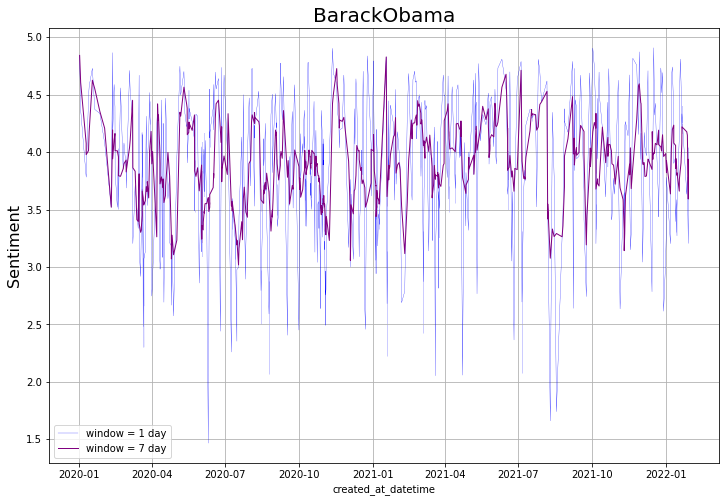

In [24]:
fig = plt.figure(figsize = (12,8))
sns.lineplot(data = df, x = 'created_at_datetime',y = 'sentiment_1D',label = 'window = 1 day',
             linewidth = .25,color = 'blue')
sns.lineplot(data = df, x = 'created_at_datetime',y = 'sentiment_7D',label = 'window = 7 day',
             linewidth = 1,color = 'purple')


plt.grid()
plt.ylabel("Sentiment",fontsize = 16)
#plt.xlim(datetime.date(2020, 1, 1),datetime.date(2021,12,1))
#plt.ylim([0,5])
plt.legend()
plt.title(f"{screen_name}",fontsize = 20)
plt.show()

# Tweet Hours and Days

##  Histogram of Tweet Day of the Week
Create a column in the dataframe called `day` which has the day of the week of each tweet.  We get the day of the week of a tweet with the `dt.day_name()` function.  

We can then make a histogram of the day of the user's tweets. 

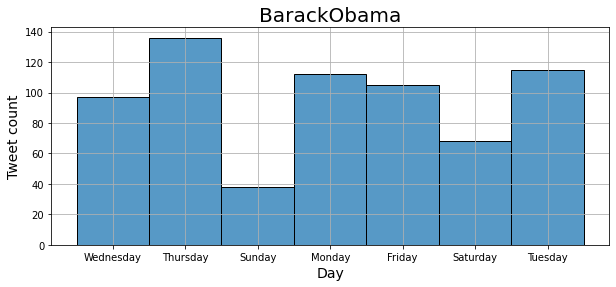

In [25]:
df['day'] = df.created_at_datetime.dt.day_name()   #get the day of the tweet

fig = plt.figure(figsize = (10,4))
sns.histplot(data = df, x = 'day')
plt.title(f"{screen_name}",fontsize = 20)
plt.ylabel("Tweet count",fontsize = 14)
plt.xlabel("Day",fontsize = 14)
plt.grid()
plt.show()

##  Histogram of Tweet Hour
Create a column in the dataframe called `hour` which has the hour of each tweet.  We get the day of the week of a tweet with the `dt.hour()` function.  

We can then make a histogram of the hour of the user's tweets. 

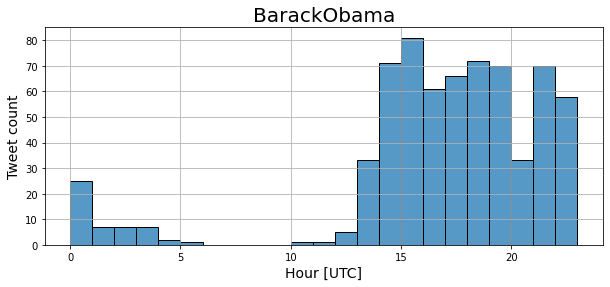

In [28]:
df['hour'] = df.created_at_datetime.dt.hour   #get the hour of the tweet

bins = list(range(0,24))


fig = plt.figure(figsize = (10,4))
sns.histplot(data = df, x = 'hour',bins = bins)
plt.title(f"{screen_name}",fontsize = 20)
plt.ylabel("Tweet count",fontsize = 14)
plt.xlabel("Hour [UTC]",fontsize = 14)
plt.grid()
plt.show()

# Geo-location with Tweet Times 

Now we will try to figure out what time zone people are based on when their Twitter activity is low.

##  Tweet Hour Histograms

Let's begin by making a histogram of the hour of each tweet for each user in the dataframe. We will need to add an `"hour"` column to the original dataframe `df_all` that contains all the users.  We can then use a `for` loop to go through all the screen names and make a histogram for each one.


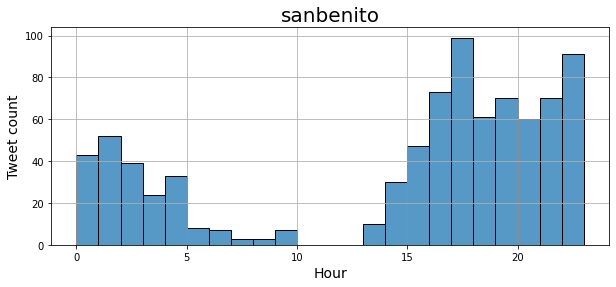

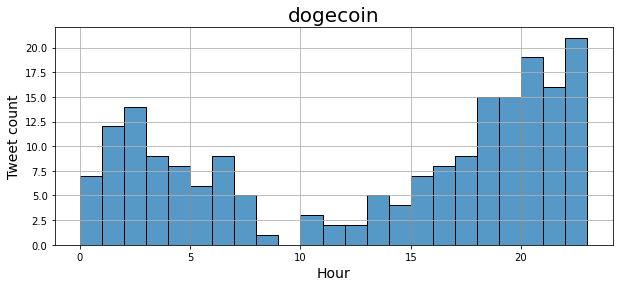

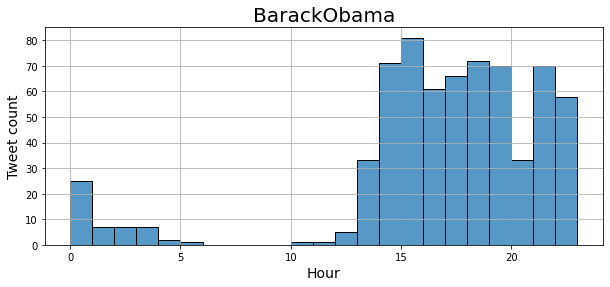

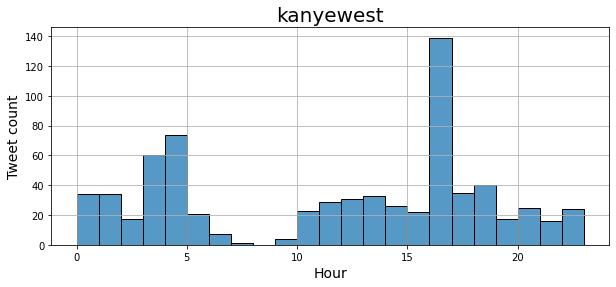

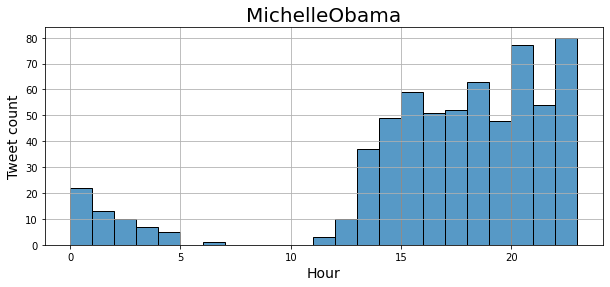

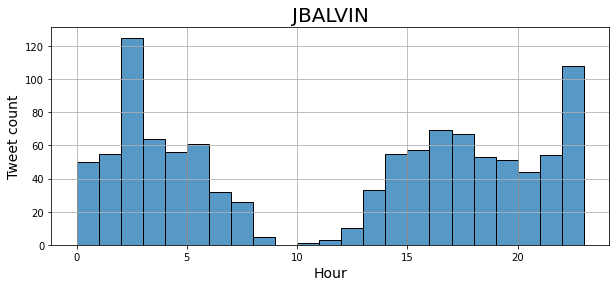

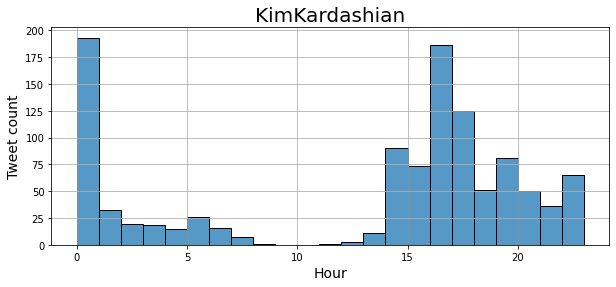

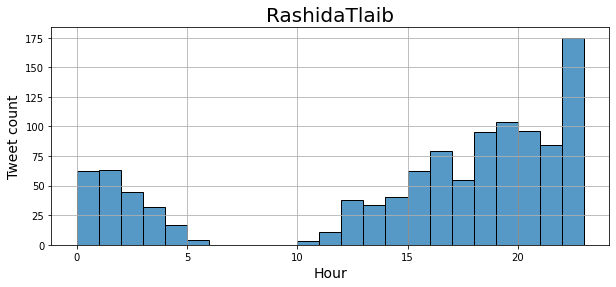

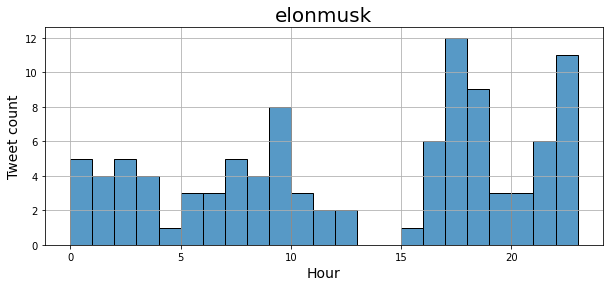

In [37]:
df_all['hour'] = df_all.created_at_datetime.dt.hour   #get the hour of the tweet

df_all.drop(df_all[df_all.screen_name=='AOC'].index, inplace = True)
df_all.drop(df_all[df_all.screen_name=='KingJames'].index, inplace = True)


bins = list(range(0,24))

for screen_name in df_all.screen_name.unique():
    df1 = df_all[df_all.screen_name==screen_name]
    fig = plt.figure(figsize = (10,4))
    sns.histplot(data = df1, x = 'hour',bins = bins)
    plt.title(f"{screen_name}",fontsize = 20)

    plt.ylabel("Tweet count",fontsize = 14)
    plt.xlabel("Hour",fontsize = 14)
    plt.grid()
    plt.show()  

## Function to Find UTC Offset based on High Low Model

The function `geolocate_utc_offset` takes as input a dataframe of tweets `df` and a list of hours when activity is low, `low_hours` and returns the UTC offset that puts the fewest number of tweets in the low activity period.  You need a column `hour` in the dataframe that has the hour of each tweet.  

`geolocate_utc_offset` returns three things:

1. `utc_offset_min` = UTC offset to put fewest tweets in `low_hours`

2. `nlows` = list of number of tweets during `low_hours` for each possible UTC offset

3. `utc_offsets` = list of possible UTC offsets (there could be a tie for multiple offsets)

In [38]:
def geolocate_utc_offset(df,low_hours):
    nlows = []
    utc_offsets = list(range(-11,13))
    for utc_offset in utc_offsets:
        low_hours_offset = [(h-utc_offset)%24 for h in low_hours]
        nlow = len(df[df.hour.isin(low_hours_offset)])
        nlows.append(nlow)
    utc_offset_min = utc_offsets[nlows.index(min(nlows))]
    
    return utc_offset_min,nlows,utc_offsets

## Find UTC Offset

We specify `low_hours` as a list of hours when we think activity is low.  Then a `for` loop goes through each screen name and finds their UTC offset.  This `for` loop might come in handy on your homework :)

To see possible cities in the time zone corresponding to the UTC offset, use this link:

https://www.timeanddate.com/time/map/

In [39]:
low_hours = [4,5]  #hours when activity is low in local time zone 
for screen_name in df_all.screen_name.unique():
    df1 = df_all[df_all.screen_name==screen_name]
    utc_offset_min,nlows,utc_offsets = geolocate_utc_offset(df1,low_hours)
    print(f"{screen_name}: UTC offset = {utc_offset_min}")

sanbenito: UTC offset = -7
dogecoin: UTC offset = -4
BarackObama: UTC offset = -4
kanyewest: UTC offset = -3
MichelleObama: UTC offset = -5
JBALVIN: UTC offset = -5
KimKardashian: UTC offset = -5
RashidaTlaib: UTC offset = -4
elonmusk: UTC offset = -9
